In [1]:
# Libraries
import pandas as pd
from readtable import *
import numpy as np
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
# Data
airbnb = get_dists()

In [3]:
airbnb['host_since'] = (pd.to_datetime(airbnb['last_scraped']) - pd.to_datetime(airbnb['host_since'])) / np.timedelta64(1, 'D')
# columns we don't need for ML model
drop = ['id', 'month', 'last_scraped', 'host_id', 'host_name', 'neighbourhood',
       'latitude', 'longitude',
       'first_review', 'last_review',
       'scrape_batch', 'batch_YRMO',
       'instant_bookable',
       'host_location',
       'host_is_superhost',
       'cum_sum',
       'has_availability',
       'amenities',
       'neighbourhood_cleansed',
       'neighbourhood_group_cleansed',
       'avg_lat',
       'avg_lon',
       'last_app',
       'List_month_byhost_month',
    'List_month_host_overall',
    'List_month_id_overall',
       'List_month_byneigh',
       'property_type']
data = airbnb.drop(drop, axis = 1)
data.dtypes
dict_ints = {"List_month": float,
            'host_is_superhost_dum': float,
             'room_type_dum':float,
             'instant_bookable_dum':float,
             'hotel_dum':float,
            'bathrooms': float}
data = data.astype(dict_ints)
X = data.dropna(subset = ['price']).loc[:, data.columns != 'price']
y = data['price'].dropna()



In [4]:
# One hot encoding
# which variables are categorical?
dict_cats = {"host_response_time": "category",
             "room_type": "category"}

# drop amenities for now
# Need to make host_response rate as int
X['host_response_rate'] = X['host_response_rate'].str[:-1].astype(float)


In [5]:
X = X.astype(dict_cats)
encoder = OneHotEncoder(handle_unknown = "ignore")
encoder_hrt = pd.DataFrame(encoder.fit_transform(X[["host_response_time"]]).toarray())
encoder_hrt.columns = list(X["host_response_time"].unique())

# Merge with original dataset
X = X.join(encoder_hrt)

# Do same for room type
encoder_rt = pd.DataFrame(encoder.fit_transform(X[["room_type"]]).toarray())
encoder_rt.columns = list(X["room_type"].unique())

X = X.join(encoder_rt)

## Drop original variables
original = list(dict_cats.keys())
X = X.drop(original, axis = 1)


In [6]:
## GB Model
X.columns = X.columns.astype(str)
drop2 = ["nan",
       "first_appearance",
       "review_scores_accuracy",
       "within a few hours",
       "Hotel room",
       "a few days or more",
       "Private room",
       "within an hour",
       "Entire home/apt",
       "within a day",
       "hotel_dum",
       "bathrooms",
       "List_month"]
X = X.drop(drop2, axis = 1) # drop variables that aren't important
print(X.dtypes)
X = X.fillna(0)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
params = {
    "n_estimators": 500,
    "max_depth": 5,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error"}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)


host_since                        float64
host_response_rate                float64
host_listings_count               float64
host_total_listings_count         float64
accommodates                      float64
bedrooms                          float64
beds                              float64
minimum_nights                    float64
maximum_nights                    float64
availability_30                   float64
availability_60                   float64
availability_90                   float64
availability_365                  float64
number_of_reviews                 float64
review_scores_rating              float64
review_scores_cleanliness         float64
review_scores_checkin             float64
review_scores_communication       float64
review_scores_location            float64
review_scores_value               float64
calculated_host_listings_count    float64
reviews_per_month                 float64
days_since_rev                    float64
days_since_first_rev              

GradientBoostingRegressor(learning_rate=0.01, max_depth=5, min_samples_split=5,
                          n_estimators=500)

In [7]:
rmse = sqrt(mean_squared_error(y_test, reg.predict(X_test))) # manually extract rmse from mse
print(rmse) #out-of-sample rmse

155.5960098719481


Text(0.5, 1.0, 'Feature Importance')

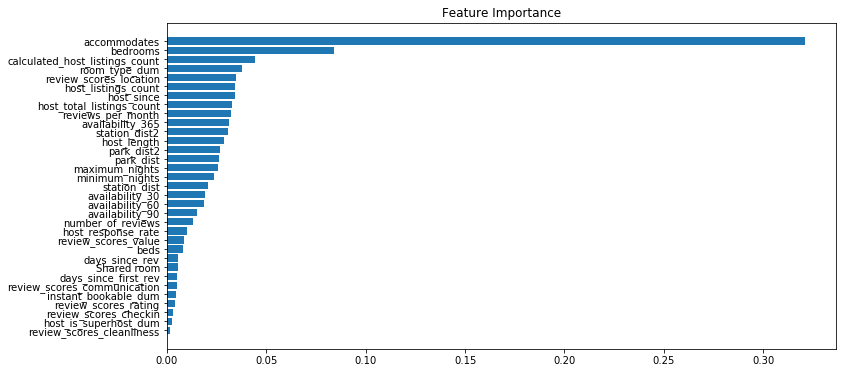

In [8]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')